# CNN classifier

https://cs230.stanford.edu/lecture/

https://deeplizard.com/learn/video/p1xZ2yWU1eo

https://deeplizard.com/learn/video/0LhiS6yu2qQ

In [128]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
from sklearn.metrics import confusion_matrix

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
NUM_WORKERS = int(os.cpu_count() / 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else None)
print(BATCH_SIZE)
print(NUM_WORKERS)

NVIDIA GeForce GTX 1650 Ti
256
6


In [3]:
BATCH_SIZE = 32

In [ ]:
# # The function to plot parameters

# def PlotParameters(model): 
#     W = model.state_dict()['linear.weight'].data
#     w_min = W.min().item()
#     w_max = W.max().item()
#     fig, axes = plt.subplots(3, 5)
#     fig.subplots_adjust(hspace=0.01, wspace=0.1)
#     for i, ax in enumerate(axes.flat):
#         if i < 15:
            
#             # Set the label for the sub-plot.
#             ax.set_xlabel("class: {0}".format(i))

#             # Plot the image.
#             ax.imshow(W[i, :].view(64, 64), vmin=w_min, vmax=w_max, cmap='seismic')

#             ax.set_xticks([])
#             ax.set_yticks([])

#         # Ensure the plot is shown correctly with multiple plots
#         # in a single Notebook cell.
#     plt.show()

In [4]:
df = datasets.ImageFolder(root='/Users/giaco/Desktop/DSSC/CVproject/train/', transform=transforms.Compose([transforms.Resize((64,64), interpolation=transforms.InterpolationMode.NEAREST),
                                                                                                        transforms.Grayscale(num_output_channels=1),
                                                                                                        transforms.ToTensor()]))
df_test = datasets.ImageFolder(root='/Users/giaco/Desktop/DSSC/CVproject/test/', transform=transforms.Compose([transforms.Resize((64,64), interpolation=transforms.InterpolationMode.NEAREST),
                                                                                                            transforms.Grayscale(num_output_channels=1),
                                                                                                            transforms.ToTensor()]))
df_train, df_val = random_split(df, (round(0.85*len(df)), round(0.15*len(df))))
    
train_loader = DataLoader(df_train, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS)
                                        
val_loader = DataLoader(df_val, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS)

test_loader = DataLoader(df_test, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=NUM_WORKERS)        

classes = df.classes

dataloader = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

dataset_size = {
    'train': len(df_train),
    'val': len(df_val),
    'test': len(df_test)
}

In [6]:
print(len(df_test), classes)
print(BATCH_SIZE, len(test_loader))

2985 ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']
32 94


In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [8]:
def imshow(img, label):
    classes = df.classes
    plt.imshow(img.permute(1, 2, 0))
    plt.title('label:' + str(classes[label]))
    plt.show()

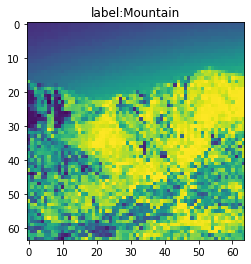

torch.Size([1, 64, 64])

In [18]:
n = int(np.random.randint(0, BATCH_SIZE))
imshow(images[n], labels[n])
images[n].shape

In [ ]:
# class ShallowNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(64*64, 100),
#             nn.ReLU(),
#             nn.Linear(100, 15),
#         )

#     def forward(self, x):
#         x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

# model = ShallowNetwork()
# model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(1, 8, 3, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.cnn2 = nn.Conv2d(8, 16, 3, stride=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.cnn3 = nn.Conv2d(16, 32, 3, stride=1)
        self.fc = nn.Linear(4608, 15)
        

    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        #x = self.softmax(x)
        return x

In [21]:
model = CNN()
model.apply(initialize_weights)
#model.to(device)
#model.state_dict()

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=4608, out_features=15, bias=True)
)

In [22]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

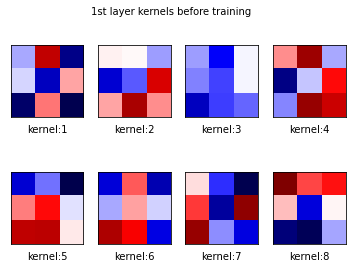

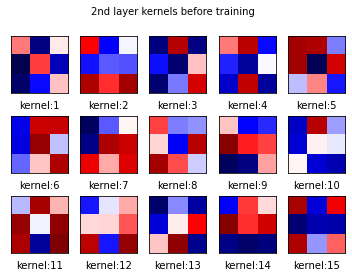

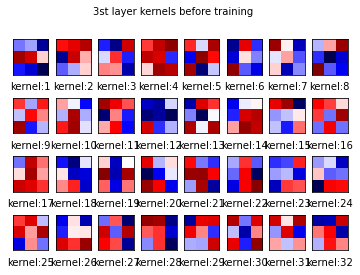

In [23]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=2, name="cnn1 layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=3, name='2nd layer kernels before training' )
plot_parameters(model.state_dict()['cnn3.weight'], number_rows=4, name="3st layer kernels before training ")

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
          
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            writer.add_scalar(f"Loss {phase}", epoch_loss, epoch)
            writer.add_scalar(f"Acc {phase}", epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
Model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
writer.flush()

Epoch 0/24
----------
train Loss: 2.7883 Acc: 0.0988
val Loss: 2.6322 Acc: 0.1200

Epoch 1/24
----------
train Loss: 2.5039 Acc: 0.1961
val Loss: 2.4196 Acc: 0.2844

Epoch 2/24
----------
train Loss: 2.3363 Acc: 0.2533
val Loss: 2.2673 Acc: 0.2978

Epoch 3/24
----------
train Loss: 2.1900 Acc: 0.3137
val Loss: 2.1471 Acc: 0.3822

Epoch 4/24
----------
train Loss: 2.0813 Acc: 0.3341
val Loss: 2.0964 Acc: 0.3600

Epoch 5/24
----------
train Loss: 1.9705 Acc: 0.3812
val Loss: 2.0466 Acc: 0.3422

Epoch 6/24
----------
train Loss: 1.8741 Acc: 0.4220
val Loss: 2.0635 Acc: 0.3467

Epoch 7/24
----------
train Loss: 1.7618 Acc: 0.4722
val Loss: 1.9729 Acc: 0.3956

Epoch 8/24
----------
train Loss: 1.7301 Acc: 0.5027
val Loss: 1.9639 Acc: 0.4089

Epoch 9/24
----------
train Loss: 1.7197 Acc: 0.4957
val Loss: 1.9694 Acc: 0.4267

Epoch 10/24
----------
train Loss: 1.7065 Acc: 0.5012
val Loss: 1.9612 Acc: 0.4133

Epoch 11/24
----------
train Loss: 1.6993 Acc: 0.5027
val Loss: 1.9715 Acc: 0.4044

Ep

In [31]:
torch.save(Model.state_dict(), "/Users/giaco/Desktop/PyTorch/model_dict.pt")

In [ ]:
writer.close()
import tensorboard
%load_ext tensorboard
# %reload_ext tensorboard
%tensorboard --logdir=runs

In [131]:
model = CNN()
model.load_state_dict(torch.load("/Users/giaco/Desktop/PyTorch/CV-project/model_dict.pt"))
model.eval()

CNN(
  (cnn1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=4608, out_features=15, bias=True)
)

In [108]:
# @torch.no_grad()
def get_predict(model, loader):
    predict_tensor = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        predict = model(images)
        # _, preds = torch.max(predict, 1)
        
        predict_tensor = torch.cat(
            (predict_tensor, predict),
            dim=0)

    return predict_tensor

In [114]:
test_predict = get_predict(model, test_loader)

In [115]:
test_predict.shape

torch.Size([2985, 15])

In [116]:
print(test_predict.requires_grad)
print(test_predict.grad)
print(test_predict.grad_fn)

True
None


c:\Users\giaco\anaconda3\lib\site-packages\torch\_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten\src\ATen/core/TensorBody.h:417.)
  return self._grad


In [132]:
with torch.no_grad():
    test_predict = get_predict(model, test_loader)

In [133]:
print(test_predict.requires_grad)
print(test_predict.grad)
print(test_predict.grad_fn)

False
None
None


In [134]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [135]:
predict_correct = get_num_correct(test_predict, torch.tensor(df_test.targets))

print(predict_correct)
print(predict_correct/len(df_test))

212
0.07102177554438861


In [136]:
print(torch.tensor(df_test.targets))
print(test_predict.argmax(dim=1))

tensor([ 0,  0,  0,  ..., 14, 14, 14])
tensor([ 7, 13,  3,  ...,  3,  3,  1])


In [137]:
stacked = torch.stack(
    (torch.tensor(df_test.targets),
    #test_predict.int()),
    test_predict.argmax(dim=1)),
    dim=1
)
stacked.shape

torch.Size([2985, 2])

In [126]:
cmt = torch.zeros(15,15, dtype=torch.int32)
for p in stacked:
    i,j = p.tolist()
    cmt[i,j] = cmt[i,j] + 1

In [138]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [139]:
cm = confusion_matrix(torch.tensor(df_test.targets), test_predict.argmax(dim=1))

Confusion matrix, without normalization
[[ 7  5  7 14 13  6  9  6  4  8 11  5  8  6  7]
 [15 23 19 26 22  7 12 11 11 13 32 16 19 15 19]
 [14 18 14 17 16 14 17  9  7 16 22 26 15 12 11]
 [11 14 13 11 14  9 13  4  8 12 16  8 10 11  6]
 [ 8 15 23 21 17 10 11 10  8  9 23 16 18  7 15]
 [10 14 23 18 21  7 20 12  8  8 11 21 15 11  9]
 [ 5 10  6  5  7  8  6  4  3  5 12 11 13  6  9]
 [15 11 19 14 16  7 18  6 10 10 22 10 10 12  9]
 [22 20 20 21 13 23 22  9 17 18 25 18 19 13 14]
 [ 1  7  6 11  9  7  9  5  8  6 13 14  9  8  2]
 [21 18 27 22 24 15 16 19 15 16 34 25 22 20 16]
 [10 20 16 19 13 11 17 16 11 11 23 15 13  8 12]
 [14 14 14 13 20  9 12  7  8 12 15 13 17 15  9]
 [ 9  8 11 16 12  7  9  7  6  4 10 14  7 13  8]
 [16 25 21 23 23  7 14 13 10 14 28 14 12 17 19]]


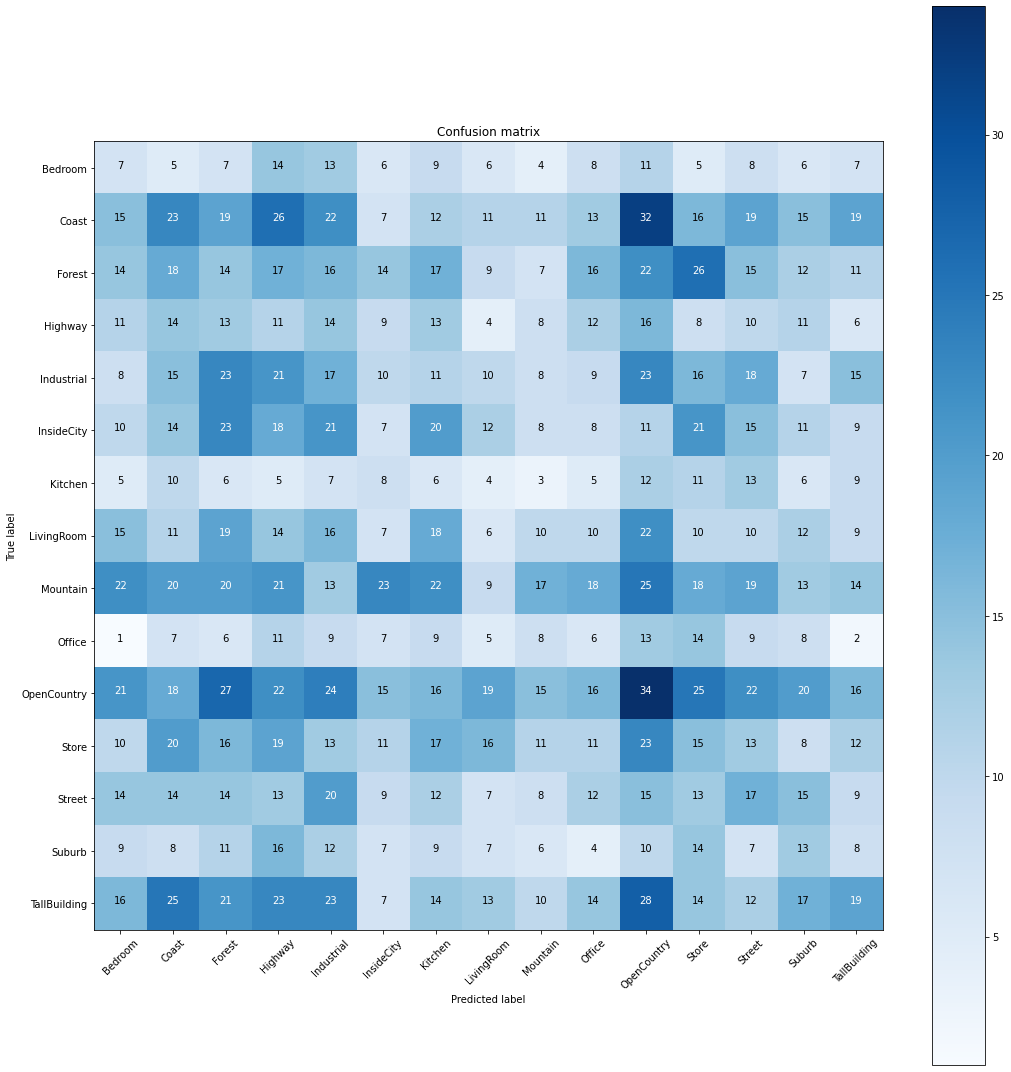

In [140]:
names = df_test.classes
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, names)

In [144]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=10):
    model.load_state_dict(torch.load("/Users/giaco/Desktop/PyTorch/model_dict.pt"))
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

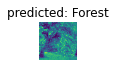

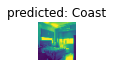

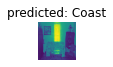

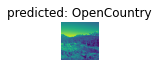

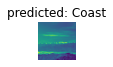

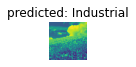

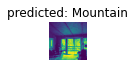

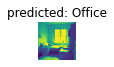

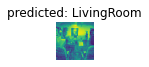

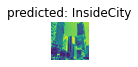

In [145]:
visualize_model(model)

In [ ]:
# softmax classifier

class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z